# CNN for ECG images classification for triage

### Imports and CUDA

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
import torch.utils.data as data

import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### ECG Image Dataset


Have ECG_image_data folder in the same directory to get path

In [4]:
# Train and Test data folders
train_folder = "ECG_Image_data/train/"
test_folder = "ECG_Image_data/test/"

Considered reducing number of images used for training and testing through data.subset in order to avoid gpu memory exceeding and long runtime, however managed to fix those issues.

In [5]:
# Train and Test ImageFolders for dataset
train_dataset = ImageFolder(train_folder,transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
]))

# subset_indices = []
# for class_idx in range(len(train_dataset.classes)):
#     class_indices = [idx for idx in range(len(train_dataset)) if train_dataset[idx][1] == class_idx]
#     subset_indices.extend(class_indices[:600])
# train_dataset = data.Subset(train_dataset, subset_indices)


test_dataset = ImageFolder(test_folder,transforms.Compose([
    transforms.Resize((150,150)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
]))

# subset_indices = []
# for class_idx in range(len(test_dataset.classes)):
#     class_indices = [idx for idx in range(len(test_dataset)) if test_dataset[idx][1] == class_idx]
#     subset_indices.extend(class_indices[:60])
# test_dataset = data.Subset(test_dataset, subset_indices)

In [6]:
img, label = train_dataset[0]
print(img.shape,label)

torch.Size([1, 150, 150]) 0


In [24]:
print("The classes are : \n",train_dataset.classes)

The classes are : 
 ['F', 'M', 'N', 'Q', 'S', 'V']


displaying first image in train_dataset

Label : F


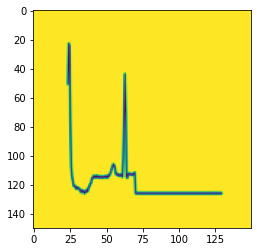

In [8]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
img, label = train_dataset[0]
display_img(img, label)

In [25]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# Preparing Data, splitting into batches

batch_size = 8
val_size = 9000
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Train size : {len(train_data)}")
print(f"Validation Size : {len(val_data)}")


#load the train and validation into batches.
train_dataloader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4)
val_dataloader = DataLoader(val_data, batch_size, shuffle = True, num_workers = 4)

Train size : 90199
Validation Size : 9000


Sample of images in train dataloader batch

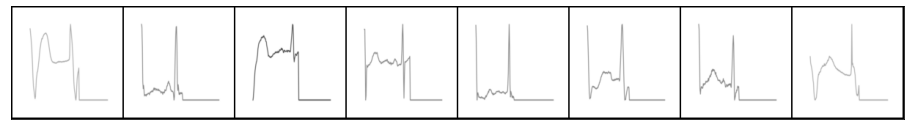

In [10]:
# Images of a batch in training data

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dataloader)

In [11]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ClassifierBase(nn.Module):
    
    # Forward
    def training_step(self, batch):
        images, labels = batch 
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        # Pass through model and get prediction outputs
        out = self(images)           
        # Calculate loss       
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        # Pass through model and get prediction outputs
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        # Calculate accuracy
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
class ECG_Classifier(ClassifierBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512,512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(512, 512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(512,512, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            
            nn.Flatten(),
            nn.Linear(8192,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(1024,6)

        )
    
    def forward(self, xb):
        return self.network(xb)

In [13]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    num_epochs = epochs
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()

        pbar = tqdm(total=len(train_loader))

        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            pbar.update(1)
            pbar.set_description(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}')

        pbar.close()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [14]:
model = ECG_Classifier().to(device)
num_epochs = 10
optimizer = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dataloader, val_dataloader, optimizer)

  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.1858, val_loss: 0.0279, val_acc: 0.9941


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0476, val_loss: 0.0145, val_acc: 0.9963


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0315, val_loss: 0.0134, val_acc: 0.9962


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0273, val_loss: 0.0117, val_acc: 0.9954


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0237, val_loss: 0.0086, val_acc: 0.9971


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0205, val_loss: 0.0201, val_acc: 0.9966


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0203, val_loss: 0.0091, val_acc: 0.9964


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0182, val_loss: 0.0095, val_acc: 0.9964


  0%|          | 0/11275 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0168, val_loss: 0.0046, val_acc: 0.9984


Epoch 10/10, Loss: 0.0105: 100%|██████████| 11275/11275 [13:07<00:00, 14.31it/s]


Epoch [9], train_loss: 0.0175, val_loss: 0.0064, val_acc: 0.9978


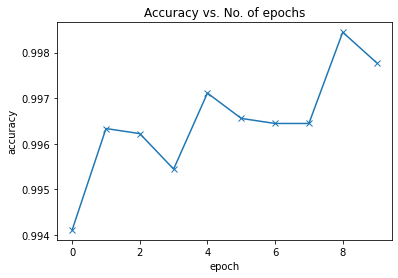

In [17]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    return
    

plot_accuracies(history)


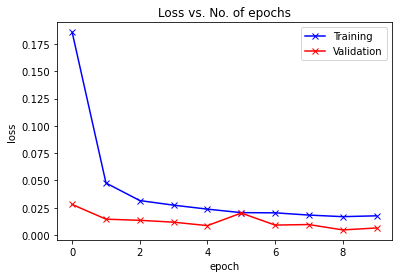

In [18]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    return

plot_losses(history)

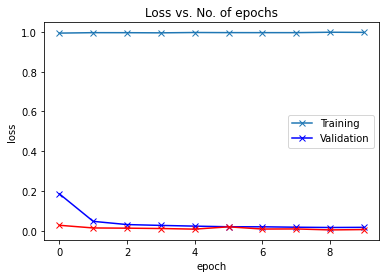

In [20]:
plot_accuracies(history)

plot_losses(history)

In [22]:
test_dataloader = DataLoader(test_dataset, batch_size, shuffle = True, num_workers = 4)

In [23]:
# for epoch in range(10):
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(' Test Accuracy: {}%'.format(accuracy))

 Test Accuracy: 99.7419250776241%
